In [3]:
# CHANGED FOR TPU 1VM:
# Install the local TF wheel
!pip install /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
!pip install -U tensorflow-addons
!pip install scikit-learn

Processing /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 28.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0.7
    Uninstalling flatbuffers-2.0.7:
      Successfully uninstalled flatbuffers-2.0.7
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninst

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    precision_score, recall_score, f1_score,
    jaccard_score, classification_report
)

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE

tf.compat.v1.enable_eager_execution()
#dataset = dataset.with_options(options)  # use this as input for your model

print("Tensorflow version " + tf.__version__)

2022-12-27 15:05:01.099661: I tensorflow/core/tpu/tpu_api_dlsym_initializer.cc:116] Libtpu path is: libtpu.so
[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


Tensorflow version 2.9.1


In [5]:
# CHANGED FOR TPU 1VM:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
except tf.errors.NotFoundError:
    strategy = tf.distribute.MirroredStrategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2022-12-27 15:05:11.289058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 15:05:15.087010: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x56133032c270 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-12-27 15:05:15.087058: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): TPU, 2a886c8
2022-12-27 15:05:15.087069: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (1): TPU, 2a886c8
2022-12-27 15:05:15.087077: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (2): TPU, 2a886c8
2022-12-27 15:05:15.087085: I tensorflow/compiler/xla/service/service.cc:17

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [6]:
df = pd.read_csv("/kaggle/input/daphnet-dataset/data.csv")
df

,input0,input1,input2,input3,input4,input5,input6,input7,input8,input9,...,input759,input760,input761,input762,input763,input764,input765,input766,input767,label
0,-45.0,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,...,181.0,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,0.0
1,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,...,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,0.0
2,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,...,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,0.0
3,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,...,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,0.0
4,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,-236.0,...,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,202.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df = df.drop_duplicates()
df

,input0,input1,input2,input3,input4,input5,input6,input7,input8,input9,...,input759,input760,input761,input762,input763,input764,input765,input766,input767,label
0,-45.0,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,...,181.0,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,0.0
1,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,...,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,0.0
2,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,...,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,0.0
3,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,...,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,0.0
4,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,-236.0,...,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,202.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116802,-109.0,-109.0,-109.0,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116803,-109.0,-109.0,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116804,-109.0,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116805,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X = df.values[:, :-1]
X.shape

(1094288, 768)

In [9]:
y = df.label.astype(int).values
y

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 42)
X_train.shape

(875430, 768)

In [11]:
def img_process(X):
    X_img = X.reshape(-1, 3, 16, 16).transpose((0, 2, 3, 1))
    minval = X_img.min(axis=(1, 2)).reshape(-1, 1, 1, 3)
    maxval = X_img.max(axis=(1, 2)).reshape(-1, 1, 1, 3)
    X_img_norm = 255 * (X_img - minval) / (maxval - minval)
    return X_img_norm.astype(int)

X_train_img = img_process(X_train)
X_val_img = img_process(X_val)
X_test_img = img_process(X_test)

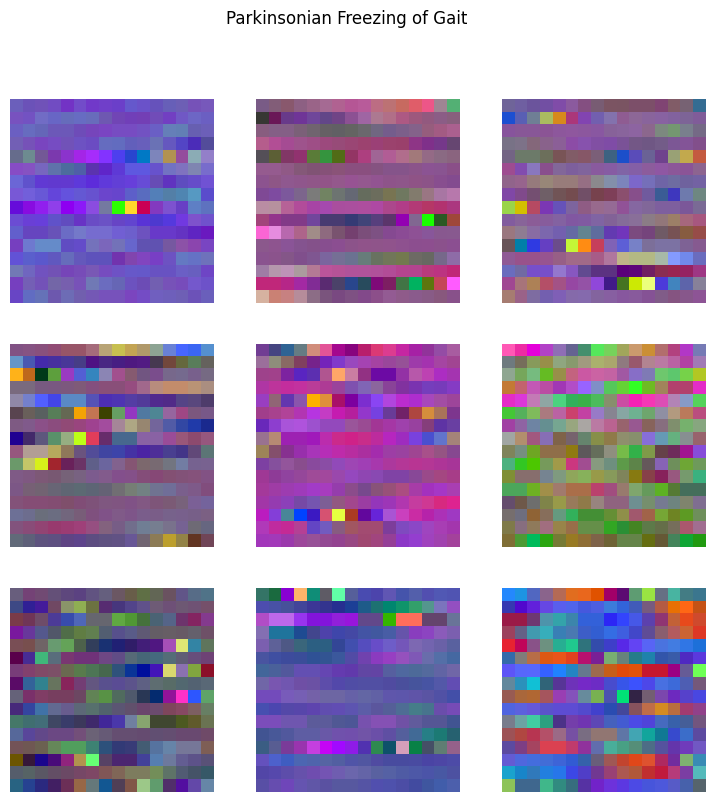

In [18]:
positive_images = X_train_img[y_train == 1]
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
plt.suptitle("Parkinsonian Freezing of Gait")
for i, idx in enumerate(np.random.randint(positive_images.shape[0], size=9)):
    axes[i//3, i%3].imshow(positive_images[idx])
    axes[i//3, i%3].axis('off')

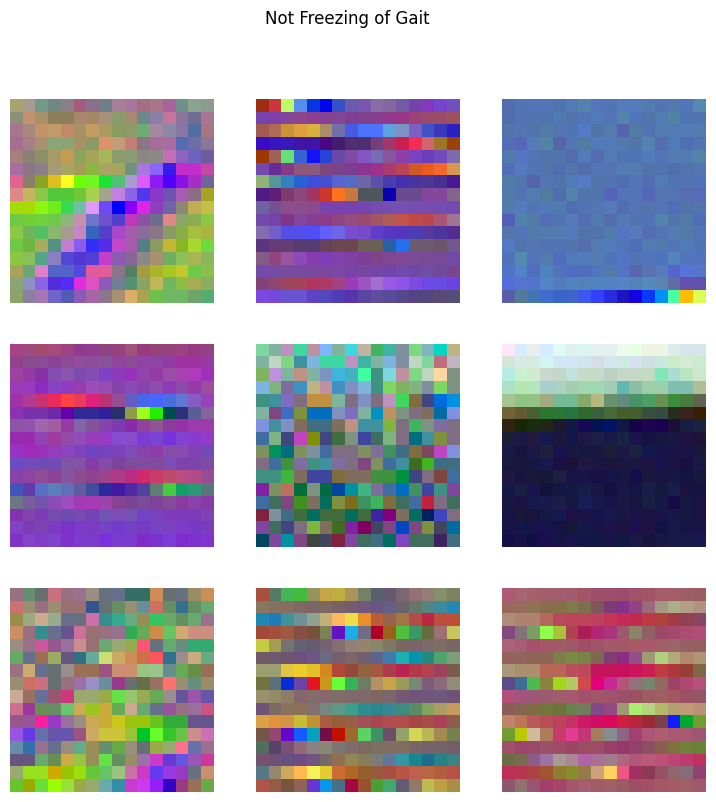

In [19]:
negative_images = X_train_img[y_train == 0]
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
plt.suptitle("Not Freezing of Gait")
for i, idx in enumerate(np.random.randint(negative_images.shape[0], size=9)):
    axes[i//3, i%3].imshow(negative_images[idx])
    axes[i//3, i%3].axis('off')

In [14]:
def train_fit_model(model):
    history = model.fit(
        x = X_train, y=y_train, validation_data=(X_val, y_val), 
        epochs=50, validation_steps=100,
        steps_per_epoch=100
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall"]):
        axes[i // 2, i % 2].plot(history.history[metric], label="Training")
        axes[i // 2, i % 2].plot(history.history["val_"+metric], label="Validation")    
        axes[i // 2, i % 2].set_title(metric.title())
        axes[i // 2, i % 2].legend()
    
    plt.show()
    
    curves = pd.DataFrame(history.history)
    
    h_test = model.predict(X_test).round().flatten()
    
    # Compile Values into a Series Object for easy display
    values = pd.Series({
        "Accuracy":accuracy_score(y_test, h_test),
        "Precision":precision_score(y_test, h_test),
        "Recall":recall_score(y_test, h_test),
        "F1 Score":f1_score(y_test, h_test),
        "Jaccard Score":jaccard_score(y_test, h_test),
    })
    
    report = pd.DataFrame(classification_report(y_test, h_test, output_dict=True)).T
    
    print(values)
    return model, curves, values, report

In [ ]:
def neural_network(layers, lr=0.0001):
    with strategy.scope():    
        model = tf.keras.Sequential([
            *(tf.keras.layers.Dense(x, activation='relu') for x in layers),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy', "Precision", "Recall"])
        
        return model

In [23]:
X_img = X.reshape(-1, 3, 16, 16).transpose((0, 2, 3, 1))
X_img.shape

(1094288, 16, 16, 3)

In [25]:
minval = X_img.min(axis=(1, 2)).reshape(-1, 1, 1, 3)
minval.shape

(1094288, 1, 1, 3)

In [27]:
maxval = X_img.max(axis=(1, 2)).reshape(-1, 1, 1, 3)
maxval.shape

(1094288, 1, 1, 3)

In [28]:
X_img_norm = (X_img - minval) / (maxval - minval)
X_img_norm.shape

(1094288, 16, 16, 3)

In [48]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_img, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_img, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_img, y_test))

In [82]:
def train_fit_img_model(model):
    history = model.fit(
        x = X_train_img, y = y_train, validation_data=(X_val_img, y_val), 
        epochs=50, validation_steps=100,
        steps_per_epoch=100
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall"]):
        axes[i // 2, i % 2].plot(history.history[metric], label="Training")
        axes[i // 2, i % 2].plot(history.history["val_"+metric], label="Validation")    
        axes[i // 2, i % 2].set_title(metric.title())
        axes[i // 2, i % 2].legend()
    
    plt.show()
    
    curves = pd.DataFrame(history.history)
    
    h_test = model.predict(X_test_img).round().flatten()
    
    # Compile Values into a Series Object for easy display
    values = pd.Series({
        "Accuracy":accuracy_score(y_test, h_test),
        "Precision":precision_score(y_test, h_test),
        "Recall":recall_score(y_test, h_test),
        "F1 Score":f1_score(y_test, h_test),
        "Jaccard Score":jaccard_score(y_test, h_test),
    })
    
    report = pd.DataFrame(classification_report(y_test, h_test, output_dict=True)).T
    
    print(values)
    return model, curves, values, report

In [85]:
from keras.applications import imagenet_utils

patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 64
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.

In [70]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=imagenet_utils.correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

In [86]:
def create_mobilevit(num_classes=5):
    inputs = keras.Input((64, 64, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

In [94]:
def train_mobilenet(model):
    history = model.fit(
        x = layers.Resizing(64, 64)(X_train_img), y = y_train, validation_data=(layers.Resizing(64, 64)(X_val_img), y_val), 
        epochs=5, validation_steps=100,
        steps_per_epoch=100
    )

    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall"]):
        axes[i // 2, i % 2].plot(history.history[metric], label="Training")
        axes[i // 2, i % 2].plot(history.history["val_"+metric], label="Validation")    
        axes[i // 2, i % 2].set_title(metric.title())
        axes[i // 2, i % 2].legend()

    plt.show()

    curves = pd.DataFrame(history.history)

    h_test = model.predict(layers.Resizing(64, 64)(X_test_img)).round().flatten()

    # Compile Values into a Series Object for easy display
    values = pd.Series({
        "Accuracy":accuracy_score(y_test, h_test),
        "Precision":precision_score(y_test, h_test),
        "Recall":recall_score(y_test, h_test),
        "F1 Score":f1_score(y_test, h_test),
        "Jaccard Score":jaccard_score(y_test, h_test),
    })

    report = pd.DataFrame(classification_report(y_test, h_test, output_dict=True)).T

    print(values)
    return model, curves, values, report

2022-12-27 09:20:59.267074: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 43029135360 exceeds 10% of free system memory.
2022-12-27 09:21:57.675750: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 43029135360 exceeds 10% of free system memory.
2022-12-27 09:22:43.754816: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1233969"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:10661"
  }
}
attr {
  key: "output_shapes"
  

Epoch 1/5


2022-12-27 09:23:15.843029: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:254] Subgraph fingerprint:13302844175323595058
2022-12-27 09:23:18.062007: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 09:23:19.923531: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 09:23:25.533549: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(5683456467396529542), session_name()
2022-12-27 09:24:00.795926: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 5683456467396529542 with session name  took 35.262278902s and succeeded
2022-12-27 09:24:00.902636: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host 

 99/100 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.8904 - precision: 0.0930 - recall: 0.0093

2022-12-27 09:24:50.419985: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(4587841593600950230), session_name()
2022-12-27 09:25:25.492053: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 4587841593600950230 with session name  took 35.071970825s and succeeded
2022-12-27 09:25:25.600826: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(4587841593600950230), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_13302844175323595058", property.function_library_fingerprint = 4848191537504848594, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property

100/100 [==============================] - ETA: 0s - loss: nan - accuracy: 0.8905 - precision: 0.0930 - recall: 0.0092

2022-12-27 09:25:31.812477: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1276356"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:10709"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

100/100 [==============================] - 189s 1s/step - loss: nan - accuracy: 0.8905 - precision: 0.0930 - recall: 0.0092 - val_loss: nan - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5


2022-12-27 09:25:54.939756: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 17622543948776890696 with session name  took 7.110465953s and succeeded
2022-12-27 09:25:54.971864: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(17622543948776890696), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_7899065551373577717", property.function_library_fingerprint = 7574419572713654241, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "128,64,64,3,;128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 09:25:54.971937: I tensorflow/

100/100 [==============================] - 56s 564ms/step - loss: nan - accuracy: 0.8987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
100/100 [==============================] - 55s 552ms/step - loss: nan - accuracy: 0.8987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
100/100 [==============================] - 56s 561ms/step - loss: nan - accuracy: 0.8987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
100/100 [==============================] - 57s 571ms/step - loss: nan - accuracy: 0.8987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


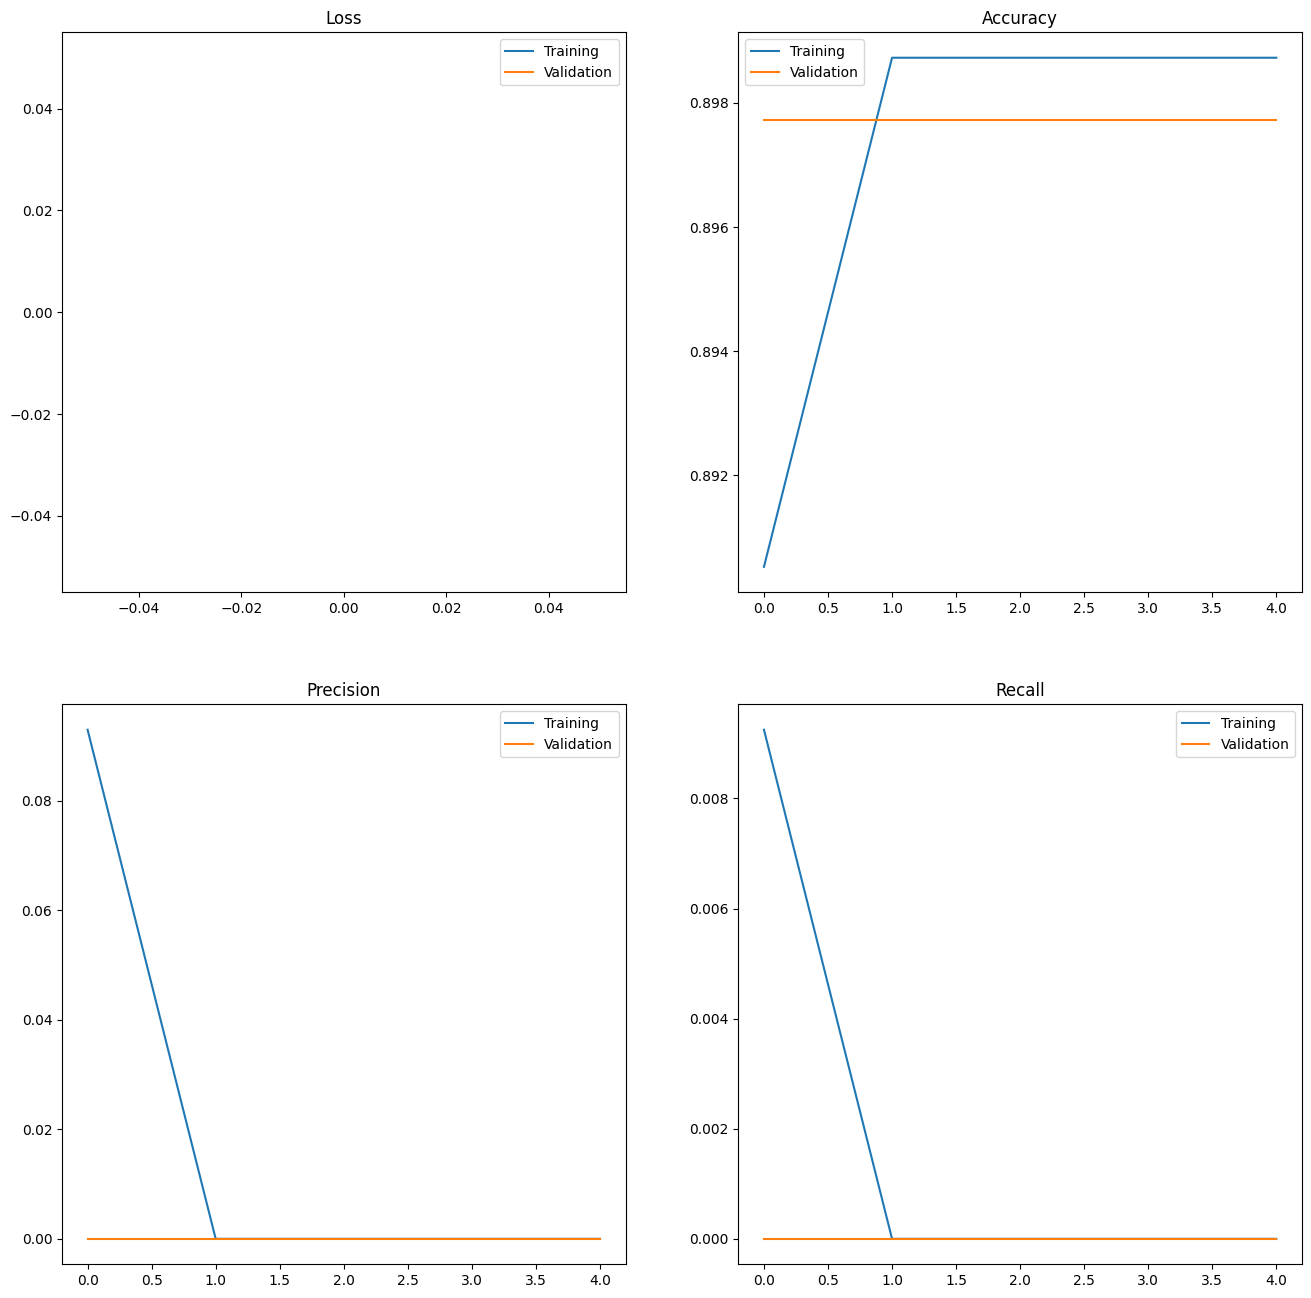

2022-12-27 09:29:54.977075: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1290150"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:10879"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

   7/3420 [..............................] - ETA: 1:09 

2022-12-27 09:30:02.550294: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 2582339249973552303 with session name  took 3.641959935s and succeeded
2022-12-27 09:30:02.577801: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(2582339249973552303), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_15920339333187922619", property.function_library_fingerprint = 5735985370488803742, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,64,64,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 09:30:02.577872: I tensorflow/core/

3418/3420 [============================>.] - ETA: 0s

2022-12-27 09:31:10.176944: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(13343489220311382771), session_name()


3420/3420 [==============================] - 79s 21ms/step


2022-12-27 09:31:13.921303: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 13343489220311382771 with session name  took 3.744267991s and succeeded
2022-12-27 09:31:13.946888: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(13343489220311382771), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_15920339333187922619", property.function_library_fingerprint = 5735985370488803742, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "3,64,64,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 09:31:13.946962: I tensorflow/cor

ValueError: Input y_pred contains NaN.

In [95]:
with strategy.scope():
    mobilevit_xxs = create_mobilevit()
    mobilevit_xxs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy', "Precision", "Recall"])

mobilevit, curves_vit, values_vit, report_vit = train_mobilenet(mobilevit_xxs)
report_vit

In [ ]:
mobilevit_xxs(layers.Resizing(64, 64)(X_test_img))

In [97]:
mobilevit_xxs.predict(layers.Resizing(64, 64)(X_test_img)).round().flatten()

# # Compile Values into a Series Object for easy display
# values = pd.Series({
#     "Accuracy":accuracy_score(y_test, h_test),
#     "Precision":precision_score(y_test, h_test),
#     "Recall":recall_score(y_test, h_test),
#     "F1 Score":f1_score(y_test, h_test),
#     "Jaccard Score":jaccard_score(y_test, h_test),
# })

# report = pd.DataFrame(classification_report(y_test, h_test, output_dict=True)).T

2022-12-27 09:43:58.229574: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1324386"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:10924"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

3420/3420 [==============================] - 70s 20ms/step


array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [4]:
dataset = tf.data.experimental.CsvDataset(
    "/kaggle/input/daphnet-dataset/data.csv",
    [tf.float32]*769, header=True
).shuffle(1000000)

In [5]:
def preprocess(*fields):
    return tf.transpose(tf.reshape(tf.stack(fields[:-1]), (3, 16, 16)), perm=(1, 2, 0)), tf.stack(fields[-1])

dataset = dataset.map(preprocess).with_options(options)

train_ds = dataset.take(800000) #.batch(512)
val_ds = dataset.skip(800000).take(100000) #.batch(512)
test_ds = dataset.skip(900000).take(100000) #.batch(512)

In [6]:
it = train_ds.take(3).as_numpy_iterator()
x1, y1 = it.next()
x2, y2 = it.next()
x3, y3 = it.next()
x1.shape, y1.shape

2022-12-27 05:05:23.782223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 17932 of 1000000
2022-12-27 05:05:33.778226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 36161 of 1000000
2022-12-27 05:05:43.771338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 54133 of 1000000
2022-12-27 05:05:53.796981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 72322 of 1000000
2022-12-27 05:06:03.771512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 90546 of 1000000
2022-12-27 05:06:13.771422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 108695 of 1000000
2022-12-27 05:06:23.794030: I tensorflow/core/kernels/data/shuffle_dataset_

KeyboardInterrupt: 

In [7]:
@tf.function
def _filtcond1(*x):
    return x[1] == 1

positive = train_ds.filter(_filtcond1)
posit = positive.take(5).as_numpy_iterator()
x4, y4 = posit.next()

2022-12-27 03:04:07.745637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 20813 of 1000000
2022-12-27 03:04:17.745488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 42008 of 1000000
2022-12-27 03:04:27.745390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 63093 of 1000000
2022-12-27 03:04:37.745681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 84387 of 1000000
2022-12-27 03:04:47.745770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 105381 of 1000000
2022-12-27 03:04:57.745446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 126419 of 1000000
2022-12-27 03:05:07.745619: I tensorflow/core/kernels/data/shuffle_dataset

In [9]:
x5, y5 = posit.next()
x6, y6 = posit.next()

Matplotlib is building the font cache; this may take a moment.


Text(0.5, 1.0, '1.0')

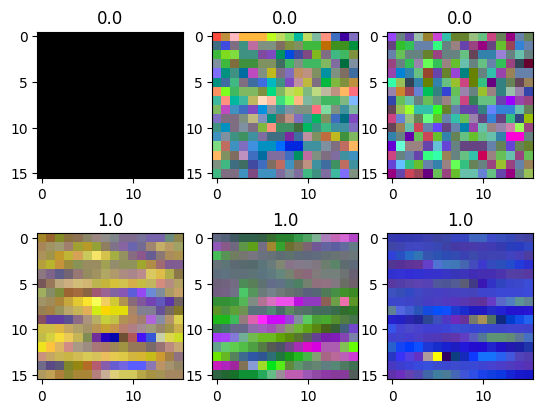

In [10]:
import matplotlib.pyplot as plt

def normalise(x):
    return (x - x.min(axis=(0, 1))) / (x.max(axis=(0, 1)) - x.min(axis=(0, 1)))

fig, axes = plt.subplots(2, 3)
axes[0, 0].imshow(normalise(x1))
axes[0, 0].set_title(y1)
axes[0, 1].imshow(normalise(x2))
axes[0, 1].set_title(y2)
axes[0, 2].imshow(normalise(x3))
axes[0, 2].set_title(y3)
axes[1, 0].imshow(normalise(x4))
axes[1, 0].set_title(y4)
axes[1, 1].imshow(normalise(x5))
axes[1, 1].set_title(y5)
axes[1, 2].imshow(normalise(x6))
axes[1, 2].set_title(y6)

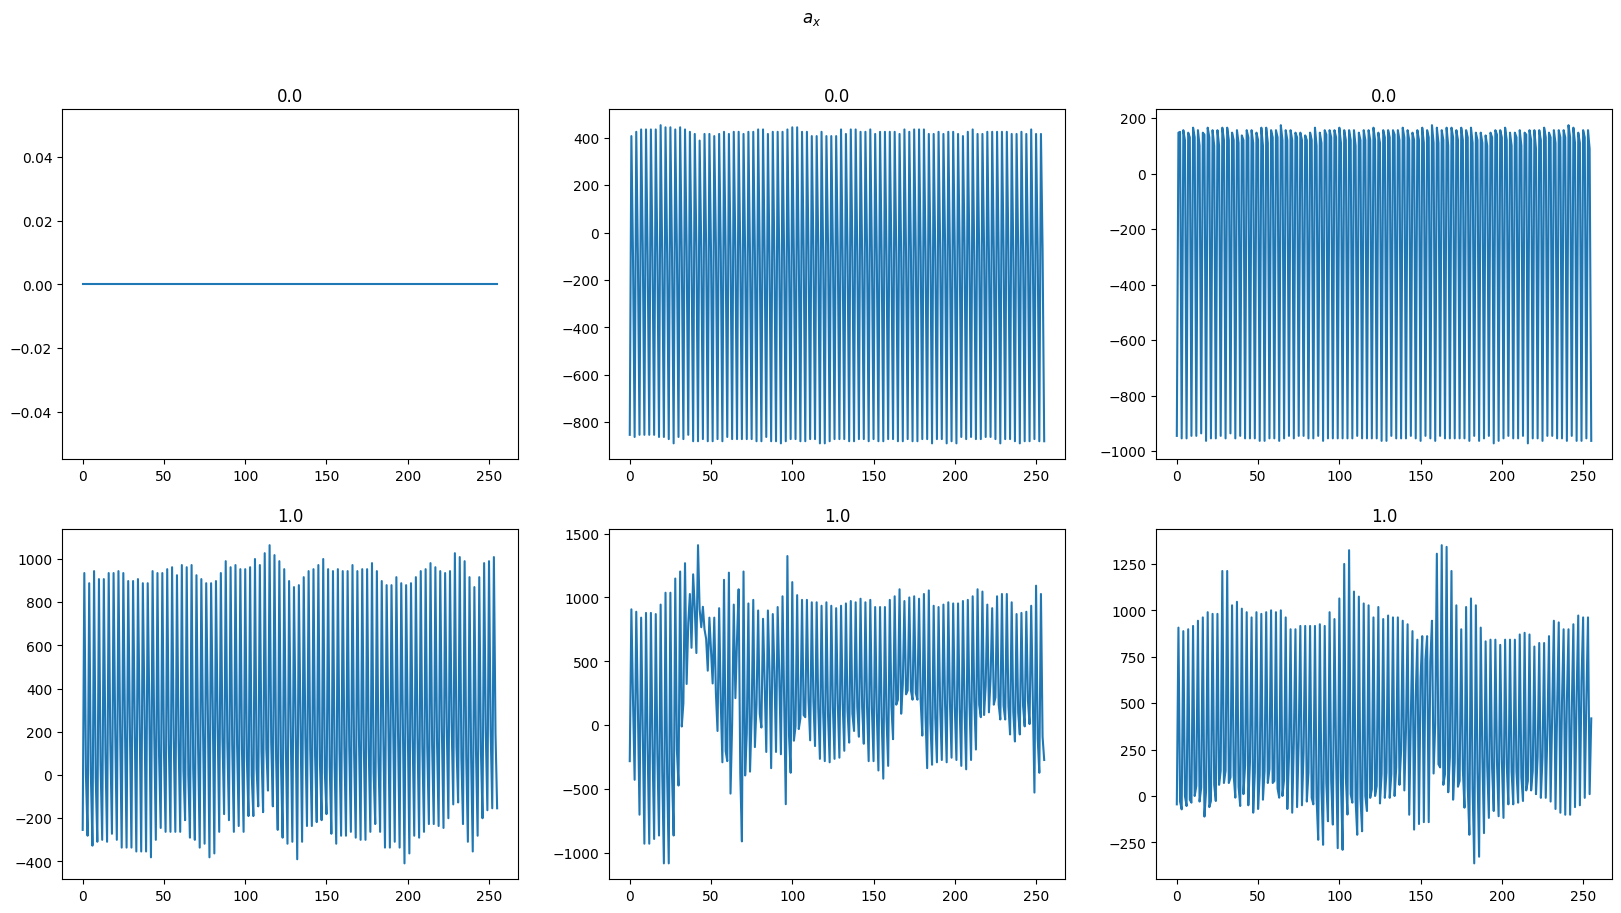

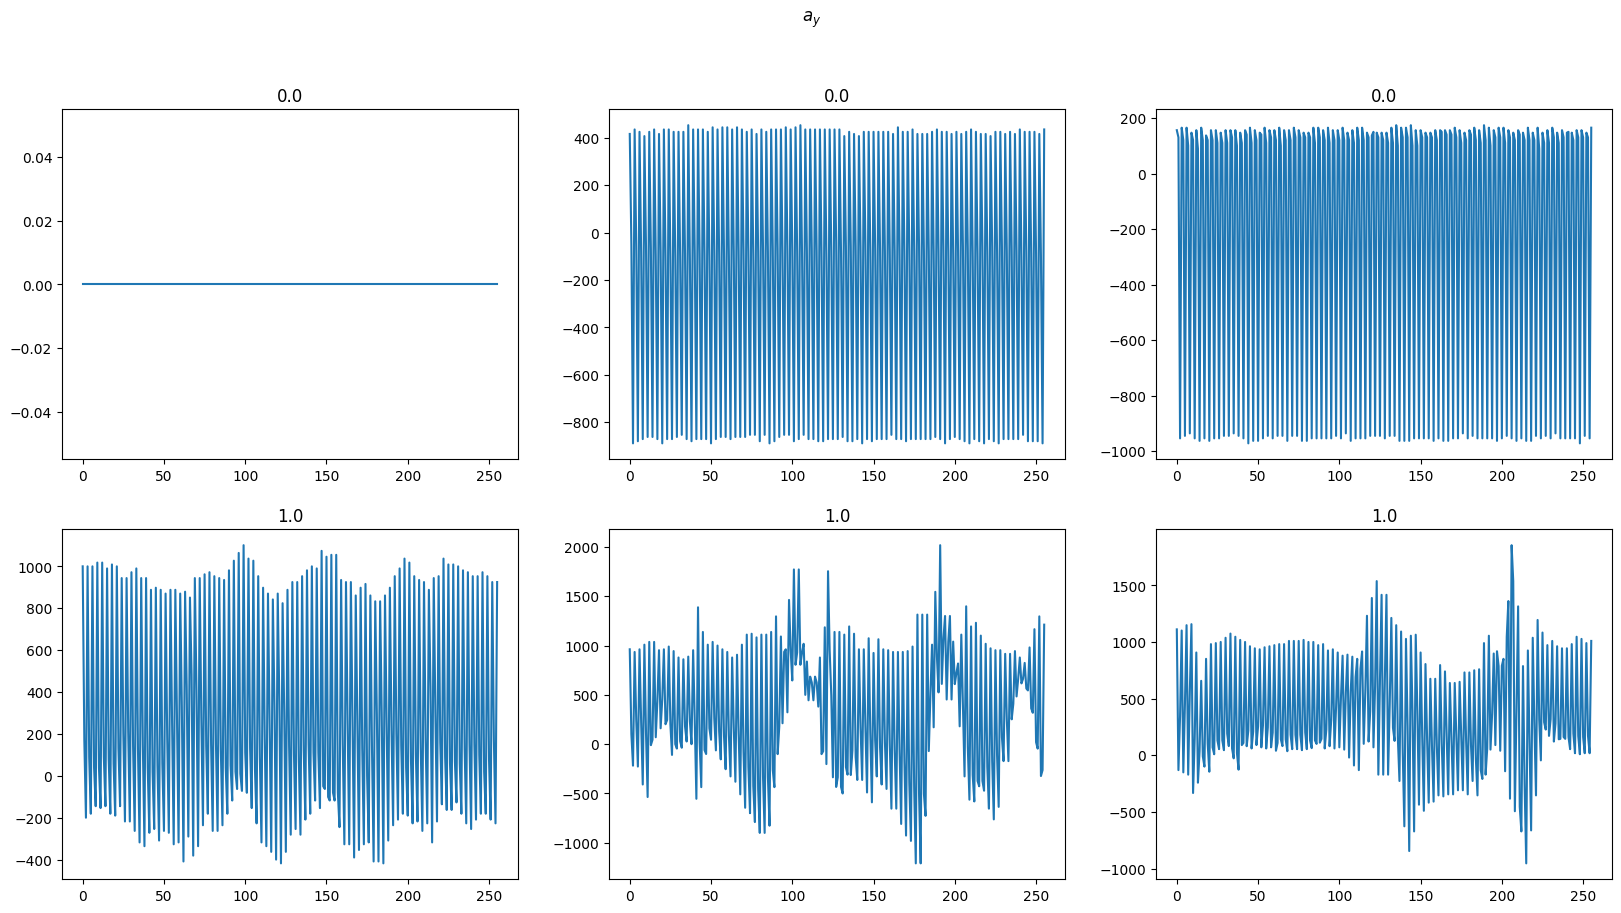

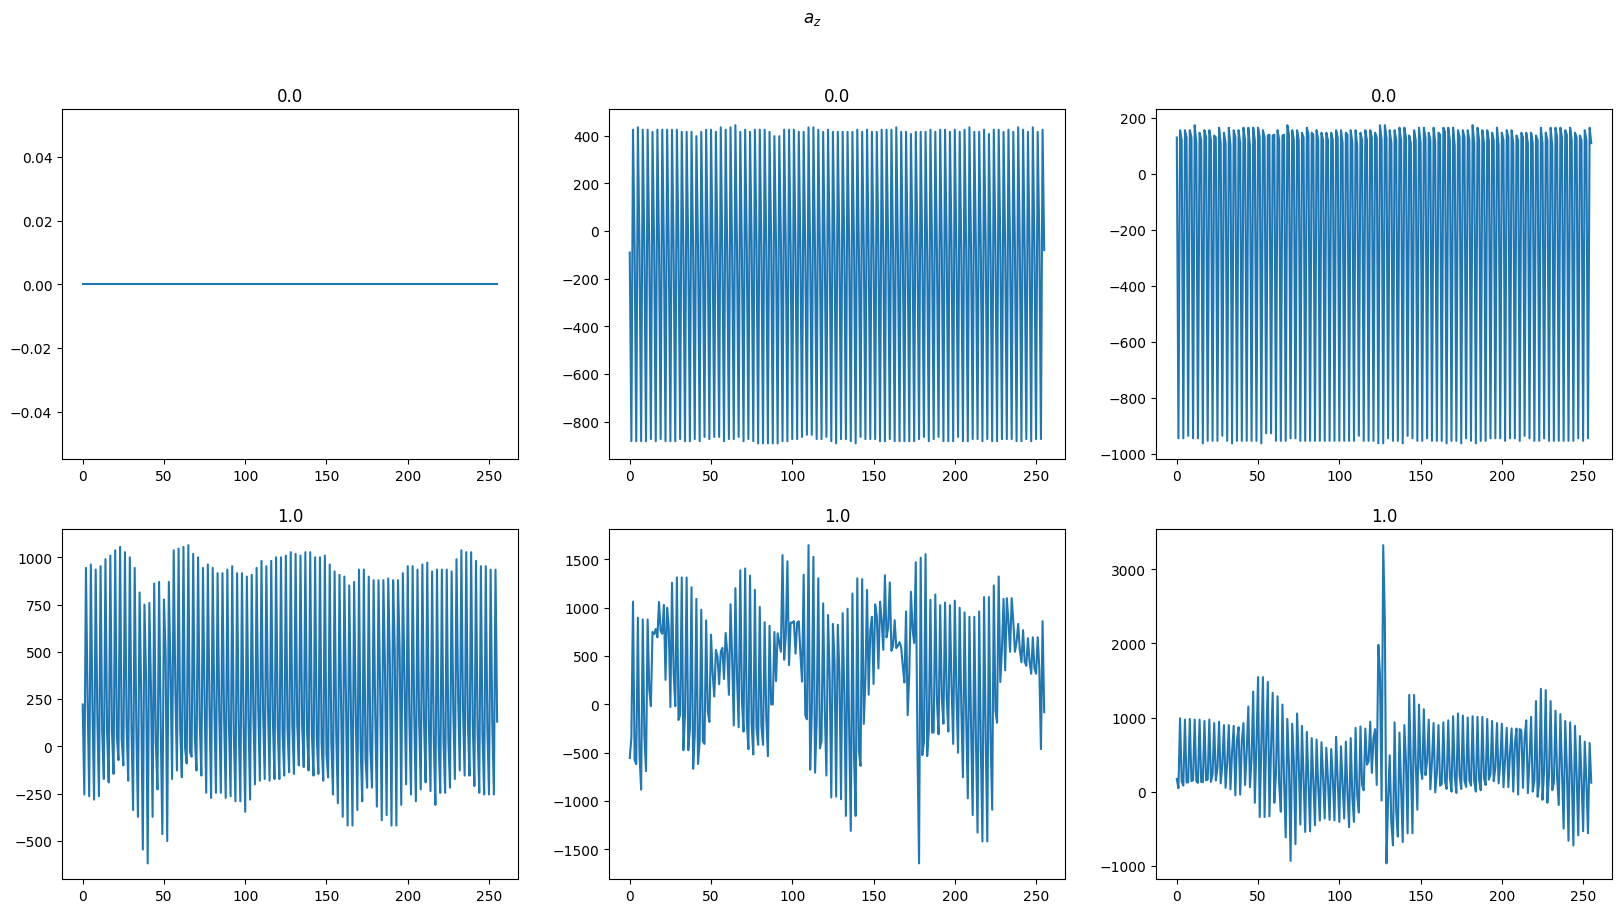

In [22]:
accx = slice(0, 256)
for name, acc in [("$a_x$", slice(0, 256)), ("$a_y$", slice(256, 512)), ("$a_z$", slice(512, 768))]:
    fig, axes = plt.subplots(2, 3, figsize = (20, 10))
    plt.suptitle(name)
    axes[0, 0].plot(x1.flatten()[acc])
    axes[0, 0].set_title(y1)
    axes[0, 1].plot(x2.flatten()[acc])
    axes[0, 1].set_title(y2)
    axes[0, 2].plot(x3.flatten()[acc])
    axes[0, 2].set_title(y3)
    axes[1, 0].plot(x4.flatten()[acc])
    axes[1, 0].set_title(y4)
    axes[1, 1].plot(x5.flatten()[acc])
    axes[1, 1].set_title(y5)
    axes[1, 2].plot(x6.flatten()[acc])
    axes[1, 2].set_title(y6)

In [23]:
def prenorm(x, y):
    return tf.Tensor(normalise(x.numpy())), int(y)

train_ds = train_ds.map(prenorm)
val_ds = val_ds.map(prenorm)
test_ds = test_ds.map(prenorm)

AttributeError: in user code:

    File "/tmp/ipykernel_12/3215385255.py", line 2, in prenorm  *
        return tf.Tensor(normalise(x.numpy())), int(y)

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [8]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 512
num_epochs = 10
image_size = 16  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
input_shape = (16, 16, 3)

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation="sigmoid")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
with strategy.scope():
    model = create_vit_classifier()
    optimizer = keras.optimizers.Adam(
        learning_rate=learning_rate
    )
    
    model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy', "Precision", "Recall"])

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_ds, validation_data=val_ds,
        epochs=num_epochs, validation_steps=100,
        steps_per_epoch=100,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

2022-12-26 06:20:45.414851: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-26 06:20:45.440115: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-12-26 06:20:46.056171: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. RandomUniform


Epoch 1/10


2022-12-26 06:21:15.531428: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:254] Subgraph fingerprint:2768919666939421418
2022-12-26 06:21:17.590356: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AdamW/AssignAddVariableOp.
2022-12-26 06:21:19.174800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AdamW/AssignAddVariableOp.
2022-12-26 06:21:21.786434: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(18018085221617905441), session_name()
2022-12-26 06:21:22.811073: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:455] Found 0 programs. Skip fingerprint registration.
2022-12-26 06:21:22.851410: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 18018085221617905441 with session name